In [1]:
#! /usr/bin/env python

In [2]:
# import modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from keras.losses import mean_squared_error
from keras import metrics

In [3]:
# pull dataset
nutrition = pd.read_pickle("./Nutrition_Full_Features.pkl")

In [4]:
#drop rows with NaN
nutrition = nutrition.dropna()

In [5]:
#Data for features
X_original = nutrition.iloc[:, 11:]
y = nutrition.iloc[:, 7]
y = y.to_numpy()

In [6]:
# normalise the data by feature column
X = preprocessing.normalize(X_original, axis=0)
X = pd.DataFrame(X_original, columns = X_original.columns) # processing loses columns headers so these must be reestablished
X = X.to_numpy()

In [7]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [8]:
#building keras Neural Network model

from keras.layers import Dense, Activation
from keras.models import Sequential
from keras import losses

# model type
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(8, activation = 'relu', input_dim = 40))

# Adding the second hidden layer
model.add(Dense(units = 16, activation = 'relu'))

# Could create for loop to check number of layers

#avoids overfitting
#https://keras.io/api/layers/regularization_layers/dropout/
model.add(keras.layers.Dropout(0.1))


# Adding the output layer
model.add(Dense(units = 1))


# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mse', metrics=['accuracy']) #currently loss is the only thing we care about

# Training the Model
history = model.fit(X_train, y_train, batch_size = 10, epochs = 50, validation_split=0.3, verbose = 0)

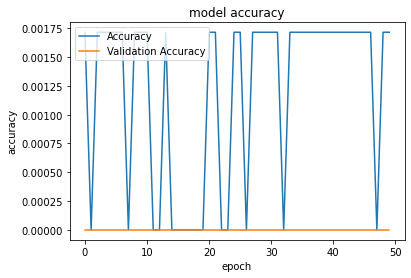

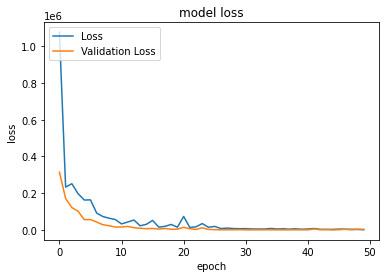

In [9]:
#plot learning curves

#accuracy no idea what this is for
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Validation Loss'], loc='upper left')
plt.show()


In [10]:
#model evaluation
score = model.evaluate(X_test, y_test, verbose = 0)[1]

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 328       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________


In [12]:
print('MSE without tuning: {}'.format(score))

MSE without tuning: 0.0


In [13]:
# get predicted values
y_pred = model.predict(X_test)

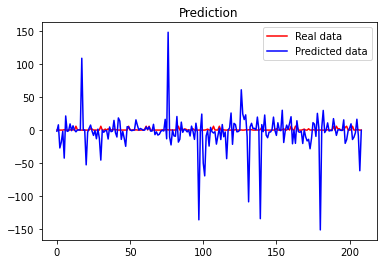

In [14]:
# plot predicted values against test values
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend(loc='upper right')
plt.show()

In [15]:
# checking the output metrics
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 13.25713313311321
Mean Squared Error: 735.4351125024159
Root Mean Squared Error: 27.118906919387733


In [16]:
y_mean = np.mean(y)
y_std = np.std(y)
print('Output Standard Deviation:', y_std)
print('Output Mean:', y_mean)

Output Standard Deviation: 1.6110865075846403
Output Mean: 0.8464732245681383


# Hyper Parameter Tuning Section

In [17]:
import kerastuner
from kerastuner import HyperModel

def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units', min_value=8, max_value=64, step=4), 
        activation = hp.Choice('dense_activation', 
                values=['relu', 'tanh','sigmoid','softmax']),
        input_dim = 40
        )
             
    )

    model.add(Dense(
        units=hp.Int('units', min_value=8, max_value=64, step=4), 
        activation = hp.Choice('dense_activation', 
                values=['relu', 'tanh','sigmoid','softmax'])
        )
             
    )
    
    model.add(
        keras.layers.Dropout(
            hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.1,
                    step=0.01)
        )
    )

    # Adding the output layer
    model.add(Dense(units = 1))


    model.compile(
        optimizer = hp.Choice('dense_optimizer',
                values=['adam','SGD','rmsprop','adadelta'] ),
        loss = 'mean_squared_error',
        metrics = ['accuracy'],
    )
    return model

In [18]:
tuner = kerastuner.tuners.RandomSearch(
            build_model,
            objective='loss',
            max_trials=200,            # increase number of trials to increase chances of better model
            executions_per_trial=2,
            project_name='hp_values',
            overwrite=True)

In [19]:
tuner.search(X_train, y_train, epochs=50)

Trial 200 Complete [00h 00m 08s]
loss: 0.5307302474975586

Best loss So Far: 0.3544536381959915
Total elapsed time: 00h 37m 19s
INFO:tensorflow:Oracle triggered exit


In [20]:
#collect best hyperparameters to rebuild model
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 52)                2132      
_________________________________________________________________
dense_1 (Dense)              (None, 52)                2756      
_________________________________________________________________
dropout (Dropout)            (None, 52)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 53        
Total params: 4,941
Trainable params: 4,941
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Training the Model
history = model.fit(X_train, y_train, batch_size = 10, epochs = 100, validation_split=0.3, verbose = 0)

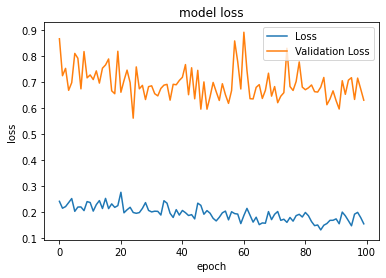

In [29]:
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [30]:
# get new predicted values with Hyperparameters
y_hp_pred = model.predict(X_test)

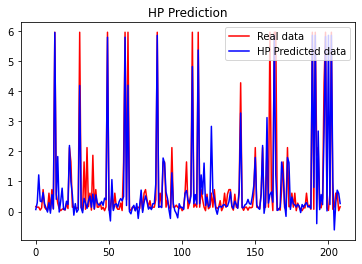

In [31]:
# plot predicted values against test values
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_hp_pred, color = 'blue', label = 'HP Predicted data')
plt.title('HP Prediction')
plt.legend(loc='upper right')
plt.show()

In [32]:
# checking the output metrics
from sklearn import metrics


print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_hp_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_hp_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_hp_pred)))

y_mean = np.mean(y_hp_pred)
y_std = np.std(y_hp_pred)
print('Output Standard Deviation:', y_std)
print('Output Mean:', y_mean)

Mean Absolute Error: 0.36320379406299325
Mean Squared Error: 0.6590035986344721
Root Mean Squared Error: 0.8117903661872763
Output Standard Deviation: 1.4030722
Output Mean: 0.7690374


In [26]:
# serialize model to JSON
model_json = model.to_json()
with open("best_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("best_model.h5")
print("Saved model to disk")

Saved model to disk


In [27]:
#delete hp_values file for easy github committing
import shutil
shutil.rmtree('./hp_values')